# Basic Anti-aliased Geological Models

I'm now going to use some of the ideas in the first notebook on anti-aliasing to develop a set of simple parametric geological models that have posteriors we can sample by MCMC.  They'll draw on ideas from several different kinds of models for best results, with what I hope will be structures transparent to both geologists and data scientists.

What we found earlier was that it was straightforward to anti-alias interfaces that were defined _implicitly_, by some function $\phi(\mathbf{x}) = 0$; the partial volume in a voxel along the interface could be expressed, to a very good approximation, as a function of the normal distance to that interface from the voxel center.  This is similar to the way interfaces are defined in the so-called _implicit_ class of models that include many packages our DARE collaborators are already working with, such as GemPy, GeoModeller, and LoopStructural.  The implicit functions these packages use are more abstract measures of geological time, rather than concrete measures like physical distance.  However, if we show that parametric anti-aliasing can work on simple models like the ones we will develop, it shouldn't be too far a step to technology that can work with real 3-D geological models.

One convenient and geologically sensible way to build a volume, though, is by composition, since in cases where multiple interfaces overlap it establishes a clear order of evaluation that resolves any interpretive ambiguities.  This is a feature of _kinematic_ models such as Noddy; LoopStructural also incorporates kinematic elements.

Let's first define an infinite-resolution geology as a composition of functions with implicitly defined interfaces; then blur out these interfaces with an anti-aliasing kernel, and evaluate on a grid for geophysics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from blockworlds import profile_timer, DiscreteGravity
from blockworlds import baseline_tensor_mesh, survey_gridded_locations

z0, L, NL = 0.0, 1000.0, 15
h = L/NL
print("z0, L, nL, h =", z0, L, NL, h)
mesh = baseline_tensor_mesh(NL, h, centering='CCN')
survey = survey_gridded_locations(L, L, 20, 20, z0)

z0, L, nL, h = 0.0 1000.0 15 66.66666666666667


I'm going to define a sequence of events here that generates something like the graben model shown in Figures 8 and 9 of Pakyuz-Charrier+ 2018.  This has several horizontal layers and two vertical faults running through them.

calc_gravity ran in 0.869 sec
calc_gravity ran in 0.001 sec
calc_gravity ran in 0.001 sec
calc_gravity ran in 0.001 sec
calc_gravity ran in 0.002 sec
calc_gravity ran in 0.002 sec


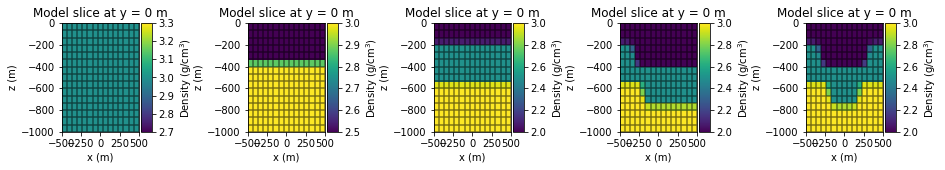

In [2]:
from implicit import GeoFunc, Basement, StratigraphicLayer, PlanarFault
from antialias import GaussianProcessAntialiasing

# Define the geology as a list of chained events
history = [Basement()]
history.append(StratigraphicLayer(history[-1]))
history.append(StratigraphicLayer(history[-1]))
history.append(PlanarFault(history[-1]))
history.append(PlanarFault(history[-1]))
# Basement density (g/cc)
histpars = [3.0]
# Thicknesses (m) and densities (g/cc) for overlying stratigraphic layers
histpars.extend([350.0, 2.5, 190.0, 2.0])
# Fault #1:  anchor point r0[x,y,z] (m), normal n[x,y,z], slip (m)
histpars.extend([-400.0, 0.0, 0.0, 0.950, 0.0, 0.312, -220.0])
# Fault #2:  anchor point r0[x,y,z] (m), normal n[x,y,z], slip (m)
histpars.extend([+400.0, 0.0, 0.0, 0.950, 0.0, -0.312, 220.0])
# Define the forward model
fwdmodel = DiscreteGravity(mesh, survey, history[0])
fwdmodel.gfunc = Basement()
fwdmodel.edgemask = profile_timer(fwdmodel.calc_gravity, h, [1.0])
# Show a sequence of how the model is built up
fig1 = plt.figure(figsize=(15, 2))
for m, part_history in enumerate(history):
    fwdmodel.gfunc = part_history
    npars = np.sum([e.npars for e in history[:m+1]])
    profile_timer(fwdmodel.calc_gravity, h, histpars[:npars])
    fwdmodel.fwd_data -= fwdmodel.edgemask * fwdmodel.voxmodel.mean()
    ax = plt.subplot(1, 5, m+1)
    fwdmodel.plot_model_slice(ax=ax)
plt.subplots_adjust(wspace=1.0)
plt.show()

The engineering on this is pretty clunky right now; obviously it needs to be cleaned up and encapsulated.  But hopefully you can see what we're doing:  the Basement class provides a background density that is then perturbed in sequence by adding and transforming layers.  I've implemented it recursively:  we start by evaluating the latest event, each of which calls the event before it to figure out what it's perturbing.  Here's a peek into the code for the PlanarFault class:

In [3]:
"""
class PlanarFault(GeoFunc):

    def __init__(self, base_gfunc):
        super().__init__(7, base_gfunc)

    def __call__(self, r, h, p):
        r0, n, s = p[-7:-4], p[-4:-1], p[-1]
        v = np.cross(np.cross([0, 0, 1], n), n)
        rdelt = s * v/l2norm(v)
        g0 = self.base_gfunc(r, h, p[:-7])
        g1 = self.base_gfunc(r + rdelt, h, p[:-7])
        return soft_if_then(np.dot(r-r0, n), g0, g1, h)
"""

'\nclass PlanarFault(GeoFunc):\n\n    def __init__(self, base_gfunc):\n        super().__init__(7, base_gfunc)\n\n    def __call__(self, r, h, p):\n        r0, n, s = p[-7:-4], p[-4:-1], p[-1]\n        v = np.cross(np.cross([0, 0, 1], n), n)\n        rdelt = s * v/l2norm(v)\n        g0 = self.base_gfunc(r, h, p[:-7])\n        g1 = self.base_gfunc(r + rdelt, h, p[:-7])\n        return soft_if_then(np.dot(r-r0, n), g0, g1, h)\n'

The base class, GeoFunc, has as attributes some number of parameters and a "base geology" that it acts upon, which is a chained hook for some other GeoFunc.  When called, PlanarFault first works out the placement and kinematics of the fault; then evaluates the base geology on either side of the fault; and finally performs the anti-aliasing step.  The underlying geological process is always evaluated at full resolution at each stage, and the recursive call structure ensures that each geological feature is evaluated in the correct lab coordinates before anti-aliasing.  Only the voxels along each interface need to be anti-aliased, which helps keep the evaluation quick.

Let's scan some posterior slices from these models now:

In [4]:
data0 = fwdmodel.calc_gravity(h, histpars)
np.random.seed(413)
sigrel = 0.05
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

def log_likelihood(data, dpred, sigma):
    # Independent Gaussian for sake of argument
    resids = data - dpred
    resids -= resids.mean()
    return -0.5*np.sum(resids**2/sigma**2 + np.log(2*np.pi*sigma**2))

def run_grid(dsynth, p1_vals, p2_vals, p1_idx, p2_idx, fwdmodel, antialias=True):
    heff = (h if antialias else 1e-6*h)
    grid_vals = [ ]
    for p1i in p1_vals:
        for p2i in p2_vals:
            pnew = np.array(histpars)
            pnew[p1_idx], pnew[p2_idx] = p1i, p2i
            dpred = fwdmodel.calc_gravity(heff, pnew)
            grid_vals.append([p1i, p2i, log_likelihood(dpred, dsynth, sigdata)])
    grid_vals = np.array(grid_vals).T.reshape(3, len(p1_vals), len(p2_vals))
    return grid_vals

def show_contours(xg, yg, Lg, p1_vals, p2_vals, p1_0, p2_0):
    levels = 10**np.arange(-6,0.1)
    levels = np.log(10)*np.arange(-6,0.1)
    # plt.contourf(xg, yg, np.exp(Lg - Lg.max()), levels=levels)
    plt.contourf(xg, yg, Lg - Lg.max(), levels=levels)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xlim(p1_vals.min(), p1_vals.max())
    ax.set_ylim(p2_vals.min(), p2_vals.max())

In [5]:
def vet_slice(z1_idx, z2_idx, zdelt1, zdelt2, Nz, aa=True):
    z1_0, z2_0 = histpars[z1_idx], histpars[z2_idx]
    z1_vals = np.linspace(z1_0-0.5*zdelt1, z1_0+0.5*zdelt1, Nz)
    z2_vals = np.linspace(z2_0-0.5*zdelt2, z2_0+0.5*zdelt2, Nz)
    xg, yg, Lg = profile_timer(run_grid, dsynth, z1_vals, z2_vals, z1_idx, z2_idx, fwdmodel, antialias=aa)
    show_contours(xg, yg, Lg, z1_vals, z2_vals, z1_0, z2_0)

run_grid ran in 2.376 sec
run_grid ran in 2.201 sec
run_grid ran in 2.074 sec


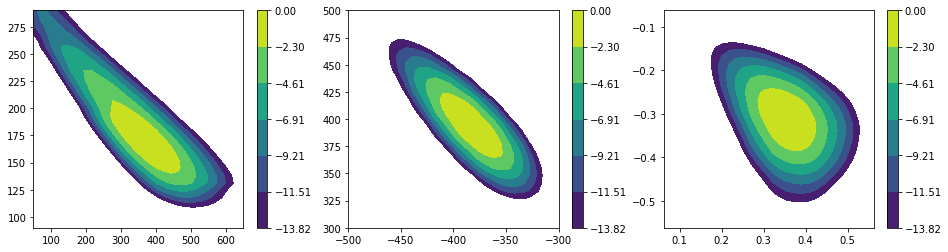

In [6]:
Nz = 30
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice( 1,  3, 600.0, 200.0, Nz)   # widths of layers on top of basement
plt.subplot(132)
vet_slice( 5, 12, 200.0, 200.0, Nz)   # the two fault displacements
plt.subplot(133)
vet_slice(10, 17,   0.5,   0.5, Nz)   # the two fault direction cosines
plt.show()

These look very reasonable!  But we can also turn anti-aliasing off, and show what happens:

run_grid ran in 2.354 sec
run_grid ran in 2.079 sec
run_grid ran in 2.062 sec


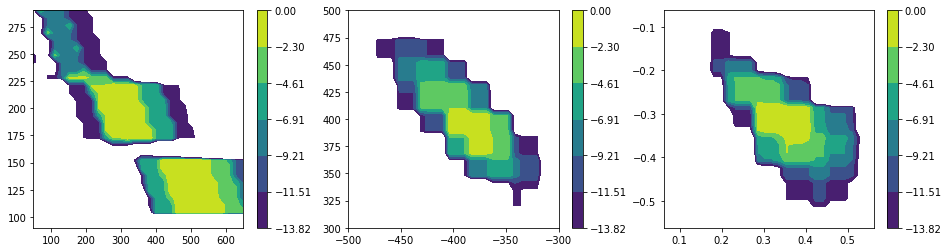

In [7]:
Nz = 30
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice( 1,  3, 600.0, 200.0, Nz, aa=False)   # widths of layers on top of basement
plt.subplot(132)
vet_slice( 5, 12, 200.0, 200.0, Nz, aa=False)   # the two fault displacements
plt.subplot(133)
vet_slice(10, 17,   0.5,   0.5, Nz, aa=False)   # the two fault direction cosines
plt.show()

## Sampling with Riemann

Let's try to sample the posterior of this model now using our home-brewed sampling framework.

In [13]:
from riemann import Sampler, Model
from riemann.proposals.randomwalk import AdaptiveMetropolisRandomWalk as AMRW

class GeoModel(Model):
    
    def __init__(self, fwdmodel, dsynth, sigdata, h):
        self.fwdmodel = fwdmodel
        self.dsynth = dsynth
        self.sigdata = sigdata
        self.h = h
        
    def log_likelihood(self, theta):
        dpred = fwdmodel.calc_gravity(self.h, theta)
        return log_likelihood(dpred, dsynth, self.sigdata)

    def log_prior(self, theta):
        # Uniform improper by default
        lp = 0.0
        # Lognormals on layer densities
        lp -= 0.5*((np.log10(theta[0]) - 0.5)/0.1)**2
        lp -= 0.5*((np.log10(theta[2]) - 0.5)/0.1)**2
        lp -= 0.5*((np.log10(theta[4]) - 0.5)/0.1)**2
        # One-sided exponentials on fault points to keep near surface
        lp -= (np.inf if theta[7] < 0 else theta[7]/1.0)
        lp -= (np.inf if theta[14] < 0 else theta[7]/1.0)
        # Keep unit vectors of unit length (should reparametrize)
        lp -= (100*(np.sqrt(theta[8]**2 + theta[9]**2 + theta[10]**2) - 1.0))**2
        lp -= (100*(np.sqrt(theta[15]**2 + theta[16]**2 + theta[17]**2) - 1.0))**2
        # That's probably good for now
        return lp

In [17]:
Npars = len(histpars)
Nsamp = 10000
model = GeoModel(fwdmodel, dsynth, sigdata, h)
stepsizes = np.array([0.1, 100, 0.1, 100, 0.1,
                      100, 100, 10, 0.01, 0.01, 0.01, 100,
                      100, 100, 10, 0.01, 0.01, 0.01, 100])
proposal = AMRW(0.1*np.diag(stepsizes), 100, marginalize=True)
sampler = Sampler(model, proposal, np.array(histpars))
profile_timer(sampler.run, Nsamp)
chain = np.array(sampler._chain_thetas)
print("chain.mean =", np.mean(chain, axis=0))
print("chain.std  =", np.std(chain, axis=0))
print("acceptance fraction =", np.sum(chain[1:]-chain[:-1] != 0, axis=0)/np.float(Nsamp))

run ran in 27.973 sec
chain.mean = [ 2.98765973e+00  3.56152778e+02  2.47775676e+00  1.49330341e+02
  2.00321061e+00 -3.92687624e+02 -3.06037857e+01  2.79883108e-01
  9.73038431e-01 -1.73866435e-03  1.97473170e-01 -2.10089170e+02
  3.84427013e+02  2.55635718e+02  7.56339484e-01  9.81493717e-01
  4.69871619e-03 -1.64268229e-01  2.05654266e+02]
chain.std  = [2.43475959e-01 8.03345531e+00 7.96790588e-02 3.37219374e+01
 2.72880053e-02 2.11825637e+01 8.87572820e+01 2.12409716e-01
 1.93144687e-02 2.26153352e-02 1.01831697e-01 1.47878439e+01
 2.06295346e+01 6.34504272e+02 5.43248922e-01 1.83868340e-02
 1.71829948e-02 9.22660560e-02 2.19800385e+01]
acceptance fraction = [0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406
 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406]


In [18]:
from scipy.stats import gaussian_kde

def vet_slice_2(z1_idx, z2_idx, zdelt1, zdelt2, Nz, aa=True):
    z1_0, z2_0 = histpars[z1_idx], histpars[z2_idx]
    z1g = np.linspace(z1_0-0.5*zdelt1, z1_0+0.5*zdelt1, Nz)
    z2g = np.linspace(z2_0-0.5*zdelt2, z2_0+0.5*zdelt2, Nz)
    xy = np.vstack([chain[:,z1_idx], chain[:,z2_idx]])
    kde = gaussian_kde(xy)
    xg, yg = np.meshgrid(z1g, z2g)
    xyg = np.array([xg, yg]).reshape(2,-1)
    zg = kde(xyg).reshape(xg.shape)
    plt.contourf(xg, yg, zg)
    plt.colorbar()

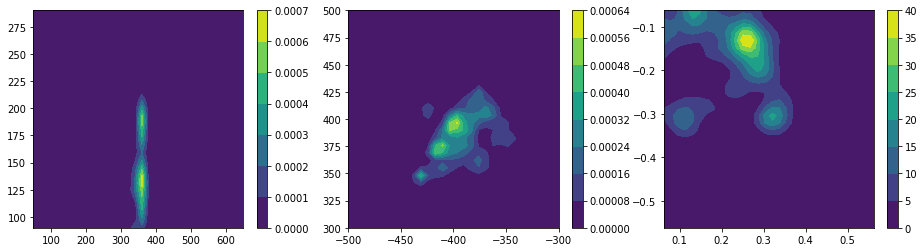

In [19]:
Nz = 30
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice_2( 1,  3, 600.0, 200.0, Nz)   # widths of layers on top of basement
plt.subplot(132)
vet_slice_2( 5, 12, 200.0, 200.0, Nz)   # the two fault displacements
plt.subplot(133)
vet_slice_2(10, 17,   0.5,   0.5, Nz)   # the two fault direction cosines
plt.show()

Okay, well, that's sort of where we are right now.  Oddly, it doesn't seem like something we can just trust to naive random walk methods.  Let's dig into the details later.